In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from micado.micado import micado

In [2]:
# matplotlib style
fontsize = 18
rc = {
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "font.family": "serif",
}
plt.rcParams.update(rc)

# generate data

In [3]:
# parameters
m = 5
p = 4
n = 1000
nb_gaussian_disturbances = 2  # should be between 0 and p
shared_causal_ordering = True
ica_algo = "shica_ml"
random_state = 42
rng = np.random.RandomState(random_state)

In [4]:
def sample_data(
    m,
    p,
    n,
    nb_gaussian_disturbances=0,
    shared_causal_ordering=True,
    rng=None,
):
    """
    Sample data according to our model. 
    This function was used in our synthetic experiments, as in Fig. 1.
    """
    # sources
    S_ng = rng.laplace(size=(p-nb_gaussian_disturbances, n))
    S_g = rng.normal(size=(nb_gaussian_disturbances, n))
    S = np.vstack((S_ng, S_g))

    # noise
    sigmas = np.ones((m, p)) * 1 / 2
    if nb_gaussian_disturbances != 0:
        sigmas[:, -nb_gaussian_disturbances:] = rng.uniform(size=(m, nb_gaussian_disturbances))
    N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))

    # strictly lower triangular matrices T
    T = rng.normal(size=(m, p, p))
    for i in range(m):
        T[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0
    
    # causal order P
    if shared_causal_ordering:
        P = np.eye(p)[rng.permutation(p)]
    else:
        P = np.array([np.eye(p)[rng.permutation(p)] for _ in range(m)])

    # causal effect matrices B
    if shared_causal_ordering:
        B = P.T @ T @ P
    else:
        B = np.array([Pi.T @ Ti @ Pi for Pi, Ti in zip(P, T)])

    # mixing matrices
    A = np.linalg.inv(np.eye(p) - B)

    # observations
    X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])
    
    return X, S, B, T, P

In [5]:
# generate observations X, causal order P, and causal effects B
X, S, B, T, P = sample_data(m, p, n, nb_gaussian_disturbances, shared_causal_ordering, rng)

# plot synthetic data

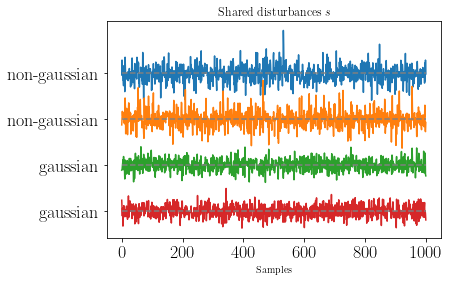

In [6]:
# plot shared disturbances
def plot_shared_disturbances(S, nb_gaussian_disturbances, height=8):
    p, n = S.shape
    fig, ax = plt.subplots(figsize=(6, 4))
    for i in range(p):
        plt.plot(S[i] - height * i)
        plt.hlines(y=-height*i, xmin=0, xmax=n, linestyles="--", colors="grey")
    plt.xlabel("Samples")
    plt.yticks(-np.arange(p) * height)
    yticklabels = ["non-gaussian"] * (p - nb_gaussian_disturbances) + ["gaussian"] * nb_gaussian_disturbances
    ax.set_yticklabels(yticklabels)
    plt.title(r"Shared disturbances $s$")
    plt.show()

plot_shared_disturbances(S, nb_gaussian_disturbances)

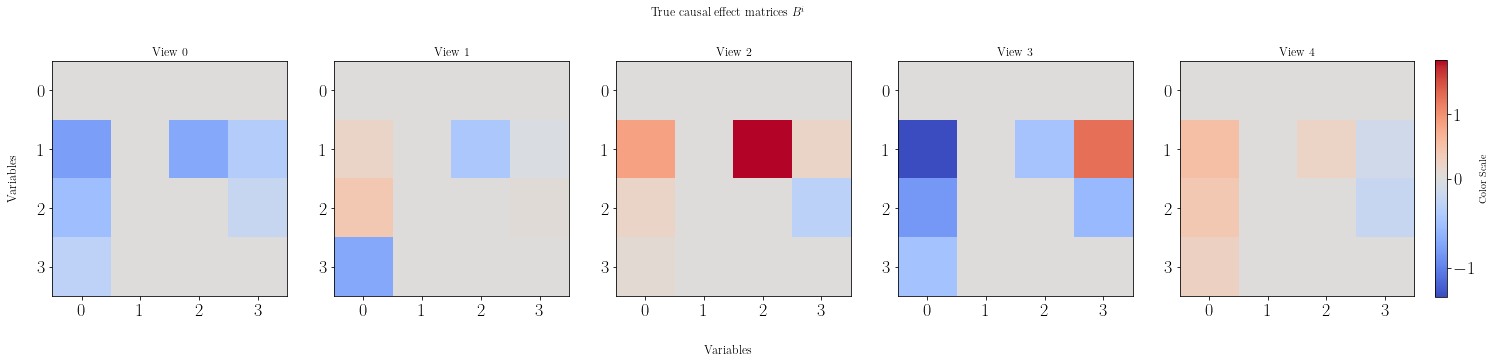

In [7]:
# plot heat maps of causal effect matrices
def plot_heat_maps(B, title=""):
    m = len(B)
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    norm = TwoSlopeNorm(vmin=np.min(B), vmax=np.max(B), vcenter=0)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(B[i], norm=norm, cmap="coolwarm")
        ax.set_title(f"View {i}")
    cbar = fig.colorbar(im, ax=axes, fraction=0.0085, pad=0.015)
    cbar.set_label("Color Scale")
    fig.suptitle(f"{title}")
    fig.supxlabel("Variables")
    fig.supylabel("Variables", x=0.1)
    plt.show()

plot_heat_maps(B, title=r"True causal effect matrices $B^i$")

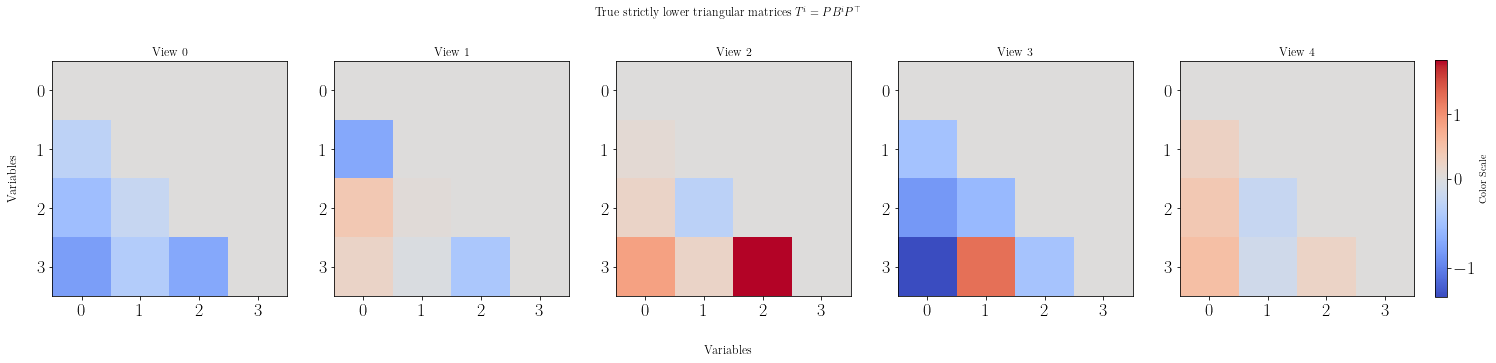

In [8]:
if shared_causal_ordering:
    title = r"True strictly lower triangular matrices $T^i = P B^i P^\top$"
else:
    title = r"True strictly lower triangular matrices $T^i = P^i B^i (P^i)^\top$"
plot_heat_maps(T, title=title)

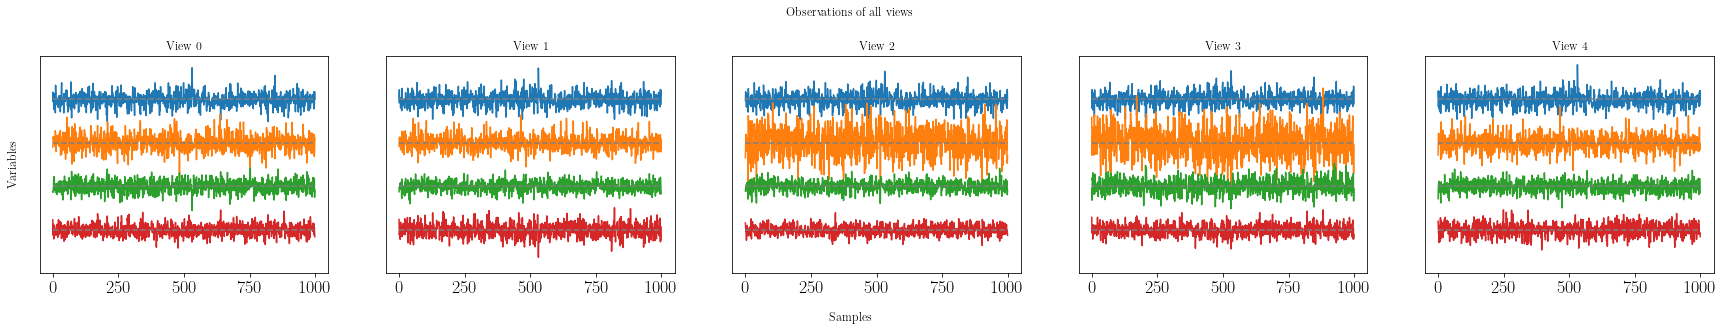

In [9]:
# plot observations
def plot_observations(X, height=10):
    m, p, n = X.shape
    fig, axes = plt.subplots(1, m, figsize=(6*m, 4), sharex=True, sharey=True)
    for i in range(m):
        for j in range(p):
            axes[i].plot(X[i, j] - height * j)
            axes[i].hlines(y=-height*j, xmin=0, xmax=n, linestyles="--", colors="grey")
        axes[i].set_yticks([])
        axes[i].set_title(f"View {i}")
        axes[i].set_ylim([-p*height, height])
    fig.supxlabel("Samples", y=-0.05)
    fig.supylabel("Variables", x=0.11)
    fig.suptitle("Observations of all views", y=1.05)
    plt.show()

plot_observations(X)

# MICaDo

In [10]:
# apply MICaDo to retrieve P and B; it takes time when ShICA-ML is used
B_estimates, T_estimates, P_estimate = micado(
    X, shared_causal_ordering=shared_causal_ordering, ica_algo=ica_algo, random_state=random_state)

In [11]:
print(f"Shape of B_estimates : {B_estimates.shape}")
print(f"Shape of T_estimates : {T_estimates.shape}")
print(f"Shape of P_estimate : {P_estimate.shape}")

Shape of B_estimates : (5, 4, 4)
Shape of T_estimates : (5, 4, 4)
Shape of P_estimate : (4, 4)


Beware that P_estimate has shape (p, p) when shared_causal_ordering==True and shape (m, p, p) when shared_causal_ordering==False.

# compute errors on $B^i$, $T^i$, and $P$ (or $P^i$)

In [12]:
error_B = np.mean((B_estimates - B) ** 2)
error_T = np.mean((T_estimates - T) ** 2)
if shared_causal_ordering:
    error_P = 1 - (P_estimate == P).all()
else:
    error_P = np.mean([1 - (Pe == Pi).all() for Pe, Pi in zip(P_estimate, P)])

print(f"The average error on B is {error_B:.4f}")
print(f"The average error on T is {error_T:.4f}")
print(f"The error on P is {error_P:.2f}")

The average error on B is 0.0004
The average error on T is 0.0004
The error on P is 0.00


# compare true and estimated matrices $T^i$

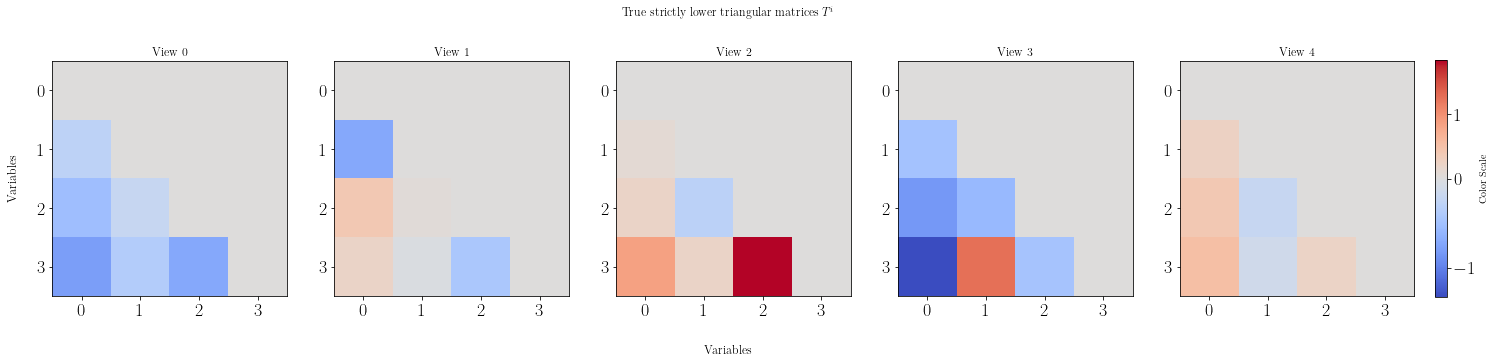

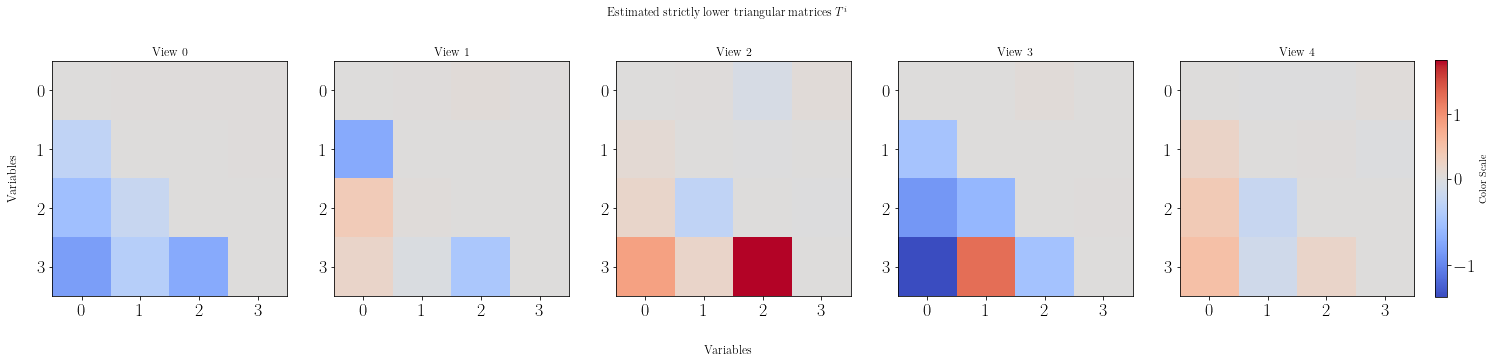

In [13]:
plot_heat_maps(T, title=r"True strictly lower triangular matrices $T^i$")
plot_heat_maps(T_estimates, title=r"Estimated strictly lower triangular matrices $T^i$")